In [1]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.5 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

alphas1
alphas2
Train acc 0.5085954157782516
Val acc 0.7967084221748401
Train acc 0.8552105543710021
Val acc 0.8988872601279317
Train acc 0.9085154584221748
Val acc 0.923940565031983
Train acc 0.9250066631130064
Val acc 0.9297707889125799
Train acc 0.9371002132196162
Val acc 0.941297974413646
Train acc 0.9440631663113006
Val acc 0.9482276119402985
Train acc 0.9473614072494669
Val acc 0.9458622068230277
Train acc 0.9512593283582089
Val acc 0.9528251599147122
Train acc 0.9536247334754797
Val acc 0.9536913646055437
Train acc 0.9574893390191898
Val acc 0.956922974413646
Train acc 0.958988539445629
Val acc 0.9578224946695096
Train acc 0.9620202558635395
Val acc 0.9597214818763327
Train acc 0.9640525053304904
Val acc 0.9572894456289979
Train acc 0.9656849680170576
Val acc 0.9605876865671642
Train acc 0.966617803837953
Val acc 0.9640858208955224
Train acc 0.9664179104477612
Val acc 0.9660514392324094
Train acc 0.9685501066098081
Val acc 0.9677172174840085
Train acc 0.9689498933901919
Val acc 

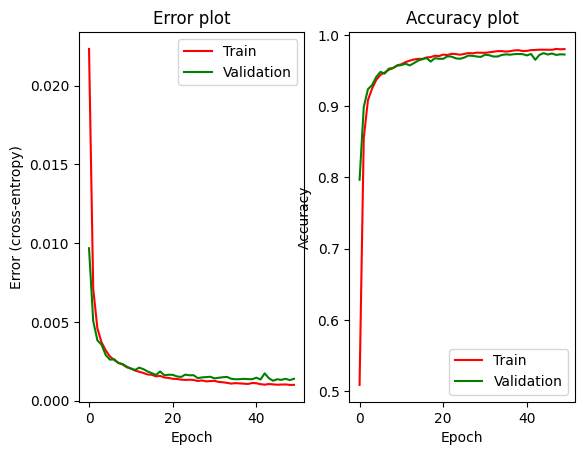

Test accuracy : 0.9761


In [3]:
from tiny_model import Net
param_list = []
model = Net(4,4,20,'drnas').cuda()
for n,p in model.named_parameters():
    if "alpha" not in n:
        param_list.append(p)
    else:
        print(n)

optimizer = torch.optim.SGD(param_list,lr=0.1)
optimizer_arch = torch.optim.Adam([model.alphas1,model.alphas2],lr=0.001,weight_decay = 1e-3)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
tau = torch.Tensor([0.1])
tau_step = (10 - 0.1) / 50
tau_curr = tau
for i in range(50):
  total_loss = 0
  total_acc = 0  
  c = 0
  for (images,labels), (images_val,labels_val) in zip(train_loader,val_loader):
    images = images.cuda()
    labels = labels.cuda()
    images_val = images_val.cuda()
    labels_val = labels_val.cuda()    
    optimizer.zero_grad()
    output = model(images,tau_curr)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()
    optimizer_arch.zero_grad()
    output_val = model(images_val,tau_curr)
    loss_val = criterion(output_val,labels_val)
    loss_val.backward()
    optimizer_arch.step()    
    total_loss+=loss.item()
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
    c+=1
  tau_curr += tau_step  
  
  #validation
  
  total_loss_val = 0
  total_acc_val = 0
  c = 0
  for images,labels in val_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images,tau_curr)
    loss = criterion(output,labels)
    
    total_loss_val +=loss.item()
    total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1
  train_errors.append(total_loss/n_train)
  train_acc.append(total_acc/n_train)
  val_errors.append(total_loss_val/n_val)
  val_acc.append(total_acc_val/n_val)
  print("Train acc",train_acc[-1])
  print("Val acc",val_acc[-1])  
print("Training complete")

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

total_acc = 0
for images,labels in test_loader:
  images = images.cuda()
  labels = labels.cuda()
  output = model(images,tau_curr)
  total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    
print("Test accuracy :",total_acc/len(test_loader.dataset))

In [4]:
print(torch.argmax(torch.nn.functional.softmax(model.alphas1,dim=-1)))
print(torch.argmax(torch.nn.functional.softmax(model.alphas2,dim=-1)))

tensor(6, device='cuda:0')
tensor(6, device='cuda:0')


In [23]:
torch.nn.functional.softmax(model.alphas1,dim=-1)

tensor([0.0581, 0.0392, 0.0356, 0.0451, 0.0380, 0.0420, 0.0681, 0.2956, 0.0422,
        0.0475, 0.1131, 0.0391, 0.0360, 0.0557, 0.0446], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

Train acc 0.8922083333333334
Val acc 0.9551196808510638
Train acc 0.9599166666666666
Val acc 0.9621841755319149
Train acc 0.965125
Val acc 0.9569481382978723
Train acc 0.9673125
Val acc 0.9483045212765957
Train acc 0.9699583333333334
Val acc 0.9674202127659575
Train acc 0.9706458333333333
Val acc 0.9650099734042553
Train acc 0.972375
Val acc 0.9689162234042553
Train acc 0.9746041666666667
Val acc 0.9635139627659575
Train acc 0.9744583333333333
Val acc 0.9712433510638298
Train acc 0.974875
Val acc 0.9704953457446809
Train acc 0.9761041666666667
Val acc 0.9716589095744681
Train acc 0.9774583333333333
Val acc 0.9728224734042553
Train acc 0.9776041666666667
Val acc 0.9733211436170213
Train acc 0.9791666666666666
Val acc 0.9698304521276596
Train acc 0.9786041666666667
Val acc 0.9757313829787234
Train acc 0.979
Val acc 0.9744015957446809
Train acc 0.9797291666666667
Val acc 0.975814494680851
Train acc 0.9800625
Val acc 0.9744015957446809
Train acc 0.9808333333333333
Val acc 0.974401595744680

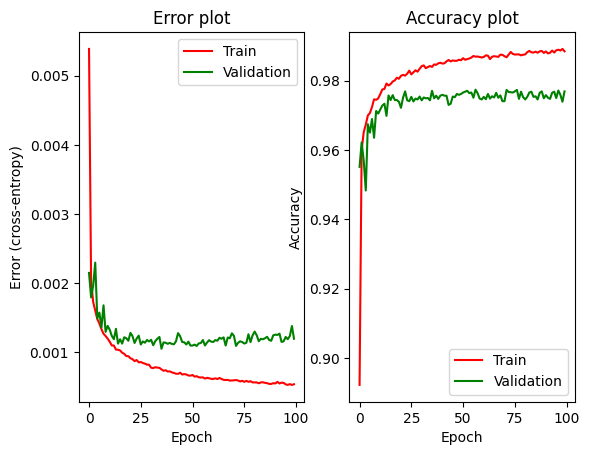

Test accuracy : 0.9799


In [6]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)
dict_test_accs = {}
idx1 = 6
idx2 = 6
from tiny_model import NetDiscrete
model = NetDiscrete(4,4,20,idx1,idx2).cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
for i in range(100):
    total_loss = 0
    total_acc = 0
    c = 0
    for (images,labels) in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
        c+=1
        #validation
        total_loss_val = 0
        total_acc_val = 0
        c = 0
    for images,labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images)
        loss = criterion(output,labels)
        total_loss_val +=loss.item()
        total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
        c+=1
    train_errors.append(total_loss/n_train)
    train_acc.append(total_acc/n_train)
    val_errors.append(total_loss_val/n_val)
    val_acc.append(total_acc_val/n_val)
    print("Train acc",train_acc[-1])
    print("Val acc",val_acc[-1])
print("Training complete")
print(idx1,idx2)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()
total_acc = 0
for images,labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images)
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
print("Test accuracy :",total_acc/len(test_loader.dataset))
test_acc = total_acc/len(test_loader.dataset)
dict_test_accs[(idx1,idx2)]= test_acc

In [4]:
output

tensor([[ 1.8928e+01, -1.8288e+01,  7.5295e-01,  3.4788e+00, -7.0339e+00,
          6.7946e+00,  5.1610e+00, -8.9177e+00,  4.6412e+00,  4.7963e+00],
        [-3.1226e+00,  1.4246e+00, -8.7353e-01,  4.1226e-01,  1.3139e+00,
         -5.6819e-01, -2.0552e+01,  1.0556e+01,  2.2826e+00,  7.2745e+00],
        [-5.6628e+00, -1.5973e+01,  5.8613e+00,  9.4386e+00, -8.8543e+00,
          5.7389e+00, -1.6846e+00, -5.9400e+00,  2.0429e+01,  1.4744e+00],
        [ 3.1243e-01, -2.1374e+01, -8.4900e+00,  9.8186e+00,  4.6963e+00,
          7.5598e+00, -2.4137e+01,  2.7969e+00,  4.0803e+00,  2.3336e+01],
        [ 7.6728e+00, -1.5491e+01,  5.0089e+00, -2.2344e+00,  8.3365e-01,
          8.7946e-01,  1.9336e+01, -1.6495e+01,  4.7675e+00,  2.7356e-01],
        [-4.6959e-01, -1.2197e+01, -7.7909e+00,  1.3752e+00,  6.9409e+00,
          4.3582e+00, -1.1357e+01, -1.2948e+00,  1.4127e+00,  1.5429e+01],
        [-1.4133e+00, -1.1837e+01, -3.2009e-01,  1.4230e+01, -3.1585e-01,
          4.5145e+00, -2.5052e+0